In [1]:
import numpy as np

from dynamic_coding_analysis.analysis_pipeline import get_data
from dynamic_coding_analysis.analysis_pipeline import process_spikes as spk

import matplotlib.pyplot as plt
from matplotlib import gridspec

from tqdm import trange
from scipy import stats

C:\Users\ilow1\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# file paths
base = 'G:/My Drive/Giocomo Lab/RandomForage/'
data_folder = base + 'aggregate_data/'
save_folder = base + 'Dynamic MEC Coding Project/fig4_images_final/'

In [3]:
# define sessions
''' NEW LIST - updated 1/12/21 w/ NP9 and NP10 cohorts'''
''' run analysis on reasonable sessions N maps = 2 '''
mice = ['Pisa', 'Hanover', 'Calais', # cue poor
        'Seattle',  'Portland', 'Quebec', 'Toronto', 'Vancouver', # cue rich (old)
        'Mumbai', 'Kerala', 'Goa', 'Punjab', 'Salvador'] # cue rich (new, NP9 = male)
mouse_IDs = ['1c', '2a', '3a', '6a', '6b', '7a', '7b', '7c', '9a', ' 9b', '9c', '9d', '10a']
sessions = [['0430_1', '0501_1', '0502_1'], # Pisa
            ['0615_2'], # Hanover
            ['0713_2'], # Calais
            ['1005_1', '1006_1', '1007_1'], # Seattle
            ['1005_2'],  # Portland
            ['1007_1'], # Quebec
            ['1111_1', '1112_1', '1113_1', '1114_1', '1115_1', '1117_1'], # Toronto
            ['1114_1', '1118_1'], # Vancouver
            ['1130_1', '1201_1', '1129_1'], # Mumbai
            ['1207_1'], # Kerala
            ['1211_1', '1210_1', '1209_1'], # Goa
            ['1217_1', '1214_1'], # Punjab
            ['1202_1'] # Salvador
           ]

print('N mice: ' + str(len(mice)))
N_sessions = 0
for s in sessions:
    N_sessions += len(s)
print('N sessions: ' + str(N_sessions))

N mice: 13
N sessions: 28


In [4]:
'''
Assign colors based on track type
see: https://personal.sron.nl/~pault/#sec:qualitative Fig. 4
cue poor : green
cue rich : pink
'''
cp_color = [17/255, 119/255, 51/255, 1]
cr_color = [204/255, 102/255, 119/255, 1]

session_colors = []
for m, session in zip(mice, sessions):
    for s in session:
        if m in ['Pisa', 'Hanover', 'Calais']:
            session_colors.append(cp_color)
        else:
            session_colors.append(cr_color)

In [5]:
# make a dict to hold data
data = {}
for session, m in zip(sessions, mice):
    data[m] = {}
    for s in session:
        data[m][s] = {}

In [6]:
# load the data
from pathlib import Path

N_cells = 0
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        d['Y'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_FRtensor.npy')
        d['B'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_spikes.npy')
        d['A'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_behavior.npy')  
        d['cells'] = np.load(data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_cellIDs.npy')
        
        # filter sessions with deleted AP/ML cells
        filt_file = data_folder + 'gap_corrected/' + m + '_' + s + '_MEC_idx.npy'
        if Path(filt_file).exists():
            print(m + '_' + s + ' corrected for probe mistargeting')
            cell_idx = np.load(filt_file)
            d['cells'] = d['cells'][cell_idx]
            d['Y'] = d['Y'][:, :, cell_idx]
            d['B'] = d['B'][:, cell_idx]
        
        N_cells += d['cells'].shape[0]

Calais_0713_2 corrected for probe mistargeting
Toronto_1112_1 corrected for probe mistargeting
Mumbai_1130_1 corrected for probe mistargeting


In [7]:
print('N cells = {}'.format(N_cells))

N cells = 4984


In [8]:
# load the behavioral data
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        folder = base + m + '/'
        data_file = m + '_' + s + '_data.mat'
        behavior = get_data.loadData(folder + data_file)
        d['behavior'] = behavior

G:/My Drive/Giocomo Lab/RandomForage/Pisa/Pisa_0430_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Pisa/Pisa_0501_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Pisa/Pisa_0502_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Hanover/Hanover_0615_2_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward'])
G:/My Drive/Giocomo Lab/RandomForage/Calais/Calais_0713_2_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward', 'framet', 'pupil', 'whisk', 'pupil_upsampled', 'whisk_upsampled', 'testvid_start'])
G:/My Drive/Giocomo Lab/RandomForage/Seattle/Seattle_1005_1_data.mat
dict_keys(['sp', 'post', 'posx', 'lickt', 'trial', 'reward', 'framet', 'pupil', 'whisk', 'pupil_upsampled', 'whisk_upsampled', 'testvid_start'])
G:/My Drive/Giocomo Lab/RandomForage/Seattle/Seattle_1006_1_data.mat

In [9]:
''' K-MEANS '''
from lvl.factor_models import KMeans as lvl_kmeans
from lvl.factor_models import NMF as lvl_soft_kmeans
from scipy.spatial.distance import cdist 
from scipy.special import logsumexp
def softmax(M):
    return np.exp(M - logsumexp(M, axis=-1, keepdims=True))

In [10]:
''' fit kmeans to get remaps '''
N = 2
model_kmeans = lvl_kmeans(n_components=N, n_restarts=100)
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        
        # fit model and get params
        model_kmeans.fit(Y_unwrapped)
        W, H = model_kmeans.factors
        Y_hat = model_kmeans.predict()
        d['kmeans'] = {}
        d['kmeans']['W'] = W
        d['kmeans']['H'] = H
        d['kmeans']['Y_hat'] = Y_hat  

In [11]:
# reassign map 0 to be the slower map
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        A = d['A']
        W = d['kmeans']['W']
        H = d['kmeans']['H']
        
        # get map indices
        map_idx = W[:, 0].astype(bool)
        trials = A[:, 2]
        map0_idx = np.zeros_like(trials)
        map1_idx = np.zeros_like(trials)
        for i, t in enumerate(np.unique(trials)):
            if map_idx[i]:
                map0_idx[trials == t] = 1
            else:
                map1_idx[trials == t] = 1
        map0_idx = map0_idx.astype(bool)
        map1_idx = map1_idx.astype(bool)

        # get running speed in each map and assign map 0 to slower map
        speed = A[:, 1]
        speed_0 = np.nanmean(speed[map0_idx])
        speed_1 = np.nanmean(speed[map1_idx])

        if speed_1 < speed_0: # swap labels
            d['map0_idx'] = 1
        else:
            d['map0_idx'] = 0

In [12]:
''' get distance to cluster on each trial '''
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        Y_unwrapped = np.reshape(Y, (Y.shape[0], -1))
        n_trials, n_cells, n_pos = Y.shape

        # get kmeans fit
        H = d['kmeans']['H']
        N = H.shape[0]
        map0_idx = d['map0_idx']

        # get centroids
        c1 = H[map0_idx]
        c2 = H[map0_idx-1]
        
        # project down to connecting line
        proj = (c1 - c2) / np.linalg.norm(c1 - c2)
        projc1 = c1 @ proj
        projc2 = c2 @ proj
        projY = Y_unwrapped @ proj
        
        # get distance
        dd = (projY - projc2) / (projc1 - projc2)
        d['dist'] = 2 * (dd - .5) # classify -1 or 1

In [13]:
# calculate each position's distance to cluster on each trial
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        Y = d['Y'].copy()
        Y = Y.transpose(0, 2, 1)
        n_trials, n_cells, n_pos = Y.shape
        
        map0_idx = d['map0_idx']
        H = d['kmeans']['H']
        N = H.shape[0]
        H_tens = H.reshape((N, n_cells, n_pos))

        # get each cluster
        c1 = H_tens[map0_idx, :, :]
        c2 = H_tens[map0_idx-1, :, :]
        proj = (c1 - c2) / np.linalg.norm(c1 - c2, axis=0, keepdims=True)

        projc1 = np.sum(c1 * proj, axis=0)[None, :]
        projc2 = np.sum(c2 * proj, axis=0)[None, :]
        projY = np.sum(Y * proj[None, :, :], axis=1)

        dd_by_pos = (projY - projc2) / (projc1 - projc2)
        dd_by_pos = 2 * (dd_by_pos - .5)
        d['pos_dist'] = dd_by_pos
        
        # calculate log likelihood
        W = d['kmeans']['W']
        n_pos = dd_by_pos.shape[1]
        K = np.tile(W[:, d['map0_idx']-1], (n_pos, 1))
        ll_pos = -K * np.log(1 + np.exp(dd_by_pos.T)) - (1 - K) * np.log(1 + np.exp(-dd_by_pos.T))
        d['ll_pos'] = ll_pos

In [14]:
''' save remap vs. stable index:
- limit "stable periods" to n_trials > 5
- stable trials = all trials except 4 trials surrounding remap point
- remap trials = two trials on each side of remap point
'''
near_N = 2
trial_min = 2*near_N + 1
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        W = d['kmeans']['W']
        trials = np.arange(0, W.shape[0]-1)

        # define remaps
        remap_idx = np.where(np.abs(np.diff(W[:, 0])))[0]
        
        # define stable
        for i in range(near_N):
            if i == 0:
                near_remaps = np.append(remap_idx, remap_idx+(i+1))
            elif i < near_N:
                near_remaps = np.append(np.append(near_remaps, remap_idx-i), remap_idx+(i+1))
        near_remaps = np.sort(near_remaps)
        stable_idx = np.setdiff1d(trials, near_remaps)
        
        # keep only remaps at least 5 trials from last remap (stable trials should by definition fit this bill)
        boundary_trials = np.insert(remap_idx, 0, 0)
        remap_idx = np.setdiff1d(remap_idx, remap_idx[np.diff(boundary_trials) < trial_min])
        remap_idx = np.sort(np.append(remap_idx, remap_idx+1))
        
        # save the data
        d['idx'] = [stable_idx, remap_idx]

In [15]:
''' get avg running speed on each trial '''
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]

        # speed
        A = d['A']
        speed = A[:, 1]
        obs_trials = A[:, 2]
        avg_speed = np.zeros_like(np.unique(obs_trials))
        for t in np.unique(obs_trials).astype(int):
            avg_speed[t] = np.mean(speed[obs_trials==t])
        d['avg_speeds'] = avg_speed

In [16]:
MIN_REMAPS = 3

# store mean speeds for each session and all speed values
med_speed_remap = []
med_speed_stable = []
sem_remaps = []
sem_stable = []   

ct = -1
for m, session in zip(mice, sessions):
    ct += 1
    med_speed_remap.append(np.zeros(len(session)))
    med_speed_stable.append(np.zeros(len(session)))
    sem_remaps.append(np.zeros(len(session)))
    sem_stable.append(np.zeros(len(session)))   
    
    for i, s in enumerate(session):
        d = data[m][s]
        stable_idx = d['idx'][0]
        remap_idx = d['idx'][1]
        
        # keep only sessions with at least MIN_REMAPS
        if remap_idx[::2].shape[0] < MIN_REMAPS:
            print(m + '_' + s + ' fewer than ' + str(MIN_REMAPS) + ' remaps')
            continue
            
        # get average speed on remap vs. stable trials
        avg_speed_remaps = d['avg_speeds'][remap_idx]
        avg_speed_stable = d['avg_speeds'][stable_idx]

        # store mean speed and SEM
        med_speed_remap[-1][i] = np.mean(avg_speed_remaps)
        sem_remaps[-1][i] = stats.sem(avg_speed_remaps)
        med_speed_stable[-1][i] = np.mean(avg_speed_stable)
        sem_stable[-1][i] = stats.sem(avg_speed_stable)

Hanover_0615_2 fewer than 3 remaps
Calais_0713_2 fewer than 3 remaps
Seattle_1005_1 fewer than 3 remaps
Portland_1005_2 fewer than 3 remaps
Quebec_1007_1 fewer than 3 remaps
Toronto_1113_1 fewer than 3 remaps
Toronto_1114_1 fewer than 3 remaps
Vancouver_1114_1 fewer than 3 remaps
Mumbai_1130_1 fewer than 3 remaps
Mumbai_1201_1 fewer than 3 remaps
Goa_1211_1 fewer than 3 remaps
Goa_1209_1 fewer than 3 remaps
Punjab_1217_1 fewer than 3 remaps
Punjab_1214_1 fewer than 3 remaps
Salvador_1202_1 fewer than 3 remaps


[42.37446449 37.22053665 46.17800234]
[29.34127221 29.41303367 42.97871651]
[0.]
[0.]
[0.]
[0.]
[ 0.         43.73005    33.99547613]
[ 0.         48.02332682 30.06050411]
[0.]
[0.]
[0.]
[0.]
[34.30341457 38.82471218  0.          0.         40.74760703 36.85923669]
[20.62987977 36.30163639  0.          0.         38.8511392  30.02207166]
[ 0.         30.31660368]
[ 0.         30.58645171]
[ 0.          0.         34.23322485]
[ 0.          0.         37.43138474]
[38.21564804]
[35.87483798]
[ 0.         33.14322264  0.        ]
[ 0.         28.15088285  0.        ]
[0. 0.]
[0. 0.]
[0.]
[0.]


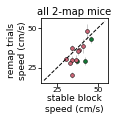

In [17]:
''' Fig. 4A -- running speed in remap vs. stable trials, all mice '''
f, ax = plt.subplots(1, 1, figsize=(1.2, 1.2))
DOT_SIZE = 15
PT_LW = 0.5
UNITY_WIDTH = 1
SEM_WIDTH = 1

N_mice_restricted = 0
N_sess_restricted = 0

i = -1
for m, session in zip(mice, sessions):
    i += 1
    
    # get data
    avg_stable = med_speed_stable[i]
    avg_remap = med_speed_remap[i]
    sem_s = sem_stable[i]
    sem_r = sem_remaps[i]
    idx = avg_stable > 0
    
    # show data
    print(avg_stable)
    print(avg_remap)
    
    if any(idx):
        N_mice_restricted += 1
        N_sess_restricted += np.sum(idx)
    
    # plot it
    if m in ['Pisa', 'Hanover', 'Calais']:
        session_color = cp_color
    else:
        session_color = cr_color
    ax.vlines(avg_stable[idx], avg_remap[idx] - sem_r[idx], avg_remap[idx] + sem_r[idx], 
              colors='k', lw=SEM_WIDTH, linestyles='solid', alpha=0.2, zorder=1)
    ax.hlines(avg_remap[idx], avg_stable[idx] - sem_s[idx], avg_stable[idx] + sem_s[idx], 
              colors='k', lw=SEM_WIDTH, linestyles='solid', alpha=0.2, zorder=1)
    ax.scatter(avg_stable[idx], avg_remap[idx], s=DOT_SIZE, 
               facecolors=session_color, edgecolors='k', lw=PT_LW, zorder=2)

# plot unity
ax.set_xticks([25, 50])
ax.set_yticks([25, 50])
ax.tick_params(which='major', labelsize=7.5, pad=0.5)
xlims = ax.get_xlim()
ylims = ax.get_ylim()
min_speed = np.min([xlims[0], ylims[0]])
max_speed = np.max([xlims[1], ylims[1]])
plt.plot([min_speed, max_speed], [min_speed, max_speed], '--k', lw=UNITY_WIDTH, alpha=1)

ax.set_xlabel('stable block\nspeed (cm/s)', fontsize=9, labelpad=1)
ax.set_ylabel('remap trials\nspeed (cm/s)', fontsize=9, labelpad=1)
ax.set_title('all 2-map mice', fontsize=10, pad=3)

f.savefig(save_folder + 'speed_remaps_all.png', dpi=400, bbox_inches='tight')
plt.show()

In [18]:
print('n mice >' + str(MIN_REMAPS) + ' remaps = ' + str(N_mice_restricted))
print('n sessions >' + str(MIN_REMAPS) + ' remaps = ' + str(N_sess_restricted))

n mice >3 remaps = 7
n sessions >3 remaps = 13


In [19]:
''' get difference in running speeds for each remap/stable block pair '''
diff_speed = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        avg_speeds = d['avg_speeds']
        
        # get indices
        stable_idx = d['idx'][0]
        remap_idx = d['idx'][1]
        if remap_idx[::2].shape[0] < MIN_REMAPS:
            continue
        remap_speeds_both = avg_speeds[remap_idx]
        remap_speeds = (remap_speeds_both[::2] + remap_speeds_both[1::2])/2
        
        # get avg stable speed by block
        bdx = np.digitize(stable_idx, remap_idx[::2])
        stable_blocks = np.zeros(remap_idx[::2].shape[0])
        for b in np.unique(bdx):
            if b < stable_blocks.shape[0]:
                stable_blocks[b] = np.mean(avg_speeds[stable_idx[bdx==b]])
            
        # calculate percent difference remap vs. stable
        diff_session = ((stable_blocks - remap_speeds) / stable_blocks)*100
        diff_speed = np.append(diff_speed, diff_session)

In [20]:
print('mean, sem')
print('diff in speeds, stable - remap: ' + str(np.round(np.mean(diff_speed), 2)) + ', ' + str(np.round(stats.sem(diff_speed), 2)))
print('n pairs = ' + str(diff_speed.shape[0]))

stat, p_diff = stats.wilcoxon(diff_speed)
print('\np = ' + str(p_diff))

mean, sem
diff in speeds, stable - remap: 9.53, 2.2
n pairs = 125

p = 0.0002017305890197435


In [21]:
# quantify n remaps total and range across sessions
n_remaps = np.zeros(N_sessions)
i = -1
for m, session in zip(mice, sessions):
    for s in session:
        i += 1
        d = data[m][s]
        remap_idx = d['idx'][1]
        n_remaps[i] = remap_idx.shape[0]
n_remaps = n_remaps/2

In [22]:
print('total N remaps = ' + str(np.sum(n_remaps)))
print('mean, sem: ' + str(np.mean(n_remaps)) + ', ' + str(stats.sem(n_remaps)))
print('range: ' + str(np.min(n_remaps)) + ' to ' + str(np.max(n_remaps)))

total N remaps = 145.0
mean, sem: 5.178571428571429, 1.234484202882132
range: 1.0 to 27.0


In [23]:
''' single session examples '''
m = 'Pisa'
s = '0430_1'
d = data[m][s]

In [24]:
print('{}_{}, n cells = {}, n remaps = {}'.format(m, s, d['cells'].shape[0], d['idx'][1][::2].shape[0]))

Pisa_0430_1, n cells = 227, n remaps = 13


In [25]:
# get data
normalized_dd_all = d['dist']
A = d['A']
speed = A[:, 1]
obs_trials = A[:, 2]
avg_speed = d['avg_speeds']

In [26]:
# get avg speed for each stable block
stable_idx = d['idx'][0]
remap_idx = d['idx'][1]
remap_speeds_both = avg_speed[remap_idx]
remap_speeds = (remap_speeds_both[::2] + remap_speeds_both[1::2])/2

# get avg stable speed by block
bdx = np.digitize(stable_idx, remap_idx[::2])
stable_blocks = np.zeros(remap_idx[::2].shape[0])
for b in np.unique(bdx):
    if b < stable_blocks.shape[0]:
        stable_blocks[b] = np.mean(avg_speed[stable_idx[bdx==b]])

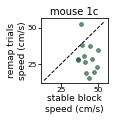

In [27]:
''' Fig. 4B - E -- examples running speed in remaps vs. stable '''
f, ax = plt.subplots(1, 1, figsize=(1.2, 1.2))
UNITY_W = 1
PT_SIZE = 15
PT_LW = 0.5
color = cp_color

# stable vs. remaps
ax.scatter(stable_blocks, remap_speeds, s=PT_SIZE, 
           facecolors=color, edgecolors='k', lw=PT_LW, alpha=0.7)

# plot unity
xlims = ax.get_xlim()
ylims = ax.get_ylim()
min_speed = np.min([xlims[0], ylims[0]])
max_speed = np.max([xlims[1], ylims[1]])
ax.plot([min_speed, max_speed], [min_speed, max_speed], 
        '--k', lw=UNITY_W, alpha=1)

# labels etc
ax.set_xticks([25, 50])
ax.set_yticks([25, 50])
ax.tick_params(which='major', labelsize=7.5, pad=0.5)
ax.set_xlabel('stable block\nspeed (cm/s)', fontsize=9, labelpad=1)
ax.set_ylabel('remap trials\nspeed (cm/s)', fontsize=9, labelpad=1)
mouse_ID = '1c'
ax.set_title('mouse {}'.format(mouse_ID), fontsize=10, pad=3)

f.savefig(save_folder + m + '_' + s + '_speed.png', dpi=400, bbox_inches='tight')
plt.show()

In [28]:
''' distance to boundary within each position bin on remap vs. stable trials--all mice '''
all_remap_dist = np.asarray([])
all_stable_dist = np.asarray([])
for m, session in zip(mice, sessions):
    for i, s in enumerate(session):
        d = data[m][s]
        p_dist = d['pos_dist'] # trials x pos bins
        
        # get remap distances
        remap_idx = d['idx'][1]
        remap_dist = np.abs(p_dist[remap_idx, :])
        all_remap_dist = np.append(all_remap_dist, remap_dist.ravel())
        
        # get stable distances
        stable_idx = d['idx'][0]
        stable_dist = np.abs(p_dist[stable_idx, :])
        all_stable_dist = np.append(all_stable_dist, stable_dist.ravel())

In [29]:
print('mean, sem')
print('remap distance to bound: ' + str(np.round(np.mean(all_remap_dist), 3)) + 
      ', ' + str(np.round(stats.sem(all_remap_dist), 3)))
print('stable distance to bound: ' + str(np.round(np.mean(all_stable_dist), 3)) + 
      ', ' + str(np.round(stats.sem(all_stable_dist), 3)))
print('N remap trials = ' + str(all_remap_dist.shape[0]/80))
print('N stable trials = ' + str(all_stable_dist.shape[0]/80))

print('IQR stable blocks: ' + str(np.round(np.percentile(all_stable_dist, 25), 3)) + 
      ' to ' + str(np.round(np.percentile(all_stable_dist, 75), 3)))

stat, p_diff = stats.ranksums(all_stable_dist, all_remap_dist)
print('\nWilcoxon rank-sums, two-sided: p = ' + str(p_diff))

mean, sem
remap distance to bound: 0.589, 0.003
stable distance to bound: 1.043, 0.001
N remap trials = 290.0
N stable trials = 8073.0
IQR stable blocks: 0.761 to 1.338

Wilcoxon rank-sums, two-sided: p = 0.0


In [30]:
''' relationship between speed and distance to boundary -- all mice '''
# bin speed by position and trial
bin_size = 5 # cm
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        speed_file = base + 'aggregate_data/gap_corrected/' + m + '_' + s + '_speed.npy'
        if Path(speed_file).exists():
            d['binned_speed'] = np.load(speed_file)
        else:
            A = d['A']
            speed = A[:, 1]
            pos = A[:, 0]
            trials = A[:, 2]
            n_trials = np.max(trials+1).astype(int)
            edges = np.arange(0, 400+bin_size, bin_size)
            bdx = np.digitize(pos, edges)

            binned_speed = np.zeros((n_trials, n_pos))
            for t in np.unique(trials).astype(int):
                for i, b in enumerate(np.unique(bdx)):
                    idx = (trials==t) & (bdx==b)
                    binned_speed[t, i] = np.mean(speed[idx])

            np.save(speed_file, binned_speed)
            d['binned_speed'] = binned_speed

In [31]:
''' single session examples '''
m = 'Pisa'
s = '0430_1'
d = data[m][s]
A = d['A']

In [32]:
def moving_avg(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [33]:
# get remap trial vs. middle of stable block indices
remaps = d['idx'][1][::2]
boundaries = np.insert(remaps, 0, 0)
stable_idx = moving_avg(boundaries, 2).astype(int)

In [34]:
# get speed near remaps vs. middle of stable blocks
binned_speed = d['binned_speed']
speed_remap = np.column_stack((binned_speed[remaps-1, :], binned_speed[remaps, :],
                                   binned_speed[remaps+1, :], binned_speed[remaps+2, :]))
speed_stable = np.column_stack((binned_speed[stable_idx-1, :], binned_speed[stable_idx, :],
                                   binned_speed[stable_idx+1, :], binned_speed[stable_idx+2, :]))

# get distance by position bin near remaps vs. middle of stable blocks
dd_by_pos = d['pos_dist']
pos_remaps = np.column_stack((dd_by_pos[remaps-1], dd_by_pos[remaps], 
                              dd_by_pos[remaps+1], dd_by_pos[remaps+2]))
pos_stable = np.column_stack((dd_by_pos[stable_idx-1], dd_by_pos[stable_idx], 
                              dd_by_pos[stable_idx+1], dd_by_pos[stable_idx+2]))

In [35]:
# example trials to plot
to_plot = np.asarray([6, 7]) # Pisa

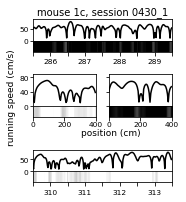

In [36]:
''' Fig. 4f, g -- examples of distance to boundary and running speed within the stable block '''
n_trials = pos_remaps.shape[0]
gs  = gridspec.GridSpec(15, 2, hspace=0, wspace=0.2)
f = plt.figure(figsize=(2.5, 3))
LW_SPEED = 1.5
MAX_SPEED = 90

if m == 'Pisa':
    mouse_ID = '1c'

# plot speed and distance to cluster for 8 stable trials
xvals = np.arange(0, 4*400, 5)                       
for r, i in enumerate(to_plot):
    if r == 0:
        ax01 = plt.subplot(gs[:2, :])
        ax11 = plt.subplot(gs[2, :])
        ax01.set_title('mouse {}, session {}'.format(mouse_ID, s), 
                       fontsize=10, pad=5)
    else:
        ax01 = plt.subplot(gs[-3:-1, :])
        ax11 = plt.subplot(gs[-1, :])
    
    # get trial numbers
    X_LABELS = []
    j = -1
    for t in range(12):
        if np.isin(t, np.asarray([1, 3, 5, 7])):
            X_LABELS.append('{}'.format(stable_idx[i] + j))
            j += 1
        else:
            X_LABELS.append('')
    
    # plot running speed
    ax01.plot(xvals, speed_stable[i], '-k', lw=LW_SPEED)
    ax01.set_ylim([0, MAX_SPEED])
    ax01.set_xticks(np.arange(0, 4*400+5, 200))
    ax01.set_xlim([0, 4*400])
    ax01.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)

    # plot dd_pos
    ax11.imshow(pos_stable[None, i, :], clim=[-1, 1], aspect='auto', cmap='binary')
    ax11.set_xticks(np.arange(0, 4*80+5, 40))
    ax11.set_xticklabels(X_LABELS)
    ax11.set_xlim([0, 4*80])
    ax11.tick_params(labelleft=False, which='major', labelsize=7.5, pad=3)
    ax11.tick_params(axis = "y", which = "both", left = False)
    
# zoom in on an example trial from each block
xvals = np.arange(0, 400, 5)                       
for r, i in enumerate(to_plot):
    if r == 0:
        ax01 = plt.subplot(gs[5:8, 1])
        ax11 = plt.subplot(gs[8:9, 1])
        idx = slice(-80, None)
        ax01.tick_params(labelleft=False)
        ax11.set_xlabel('position (cm)', fontsize=9, labelpad=1, 
                        horizontalalignment='right', x=0.5)             
    else:
        ax01 = plt.subplot(gs[5:8, 0])
        ax11 = plt.subplot(gs[8:9, 0])
        idx = slice(80)
        ax01.set_ylabel('running speed (cm/s)', fontsize=9, labelpad=3, 
                        verticalalignment='bottom', y=0.3)
    
    # plot running speed
    ax01.plot(xvals, speed_stable[i, idx], '-k', lw=LW_SPEED)
    ax01.set_ylim([0, MAX_SPEED])
    ax01.set_yticks([0, 40, 80])
    ax01.set_xticks(np.arange(0, 405, 200))
    ax01.set_xlim([0, 400])
    ax01.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)

    # plot dd_pos
    ax11.imshow(pos_stable[None, i, idx], clim=[-1, 1], aspect='auto', cmap='binary')
    ax11.set_xticks(np.arange(0, 80+5, 40))
    ax11.set_xticklabels(np.arange(0, 405, 200))
    ax11.set_xlim([0, 80])
    ax11.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
    ax11.tick_params(axis="y", which ="both", left=False)

f.savefig(save_folder + m + '_' + s + '_dist_speed_stable_alt.png', dpi=400, bbox_inches='tight')
plt.show()

In [37]:
# ''' Fig. 4f, g -- examples of distance to boundary and running speed within the stable block '''
# n_trials = pos_remaps.shape[0]
# gs  = gridspec.GridSpec(15, 2, hspace=0, wspace=0.2)
# f = plt.figure(figsize=(2, 2.5))
# LW_SPEED = 1.5
# MAX_SPEED = 90

# if m == 'Pisa':
#     mouse_ID = '1c'

# # plot speed and distance to cluster for 8 stable trials
# xvals = np.arange(0, 4*400, 5)                       
# for r, i in enumerate(to_plot):
#     if r == 0:
#         ax01 = plt.subplot(gs[:2, :])
#         ax11 = plt.subplot(gs[2, :])
#         ax01.set_title('mouse {}, session {}'.format(mouse_ID, s), 
#                        fontsize=10, pad=5)
#     else:
#         ax01 = plt.subplot(gs[-3:-1, :])
#         ax11 = plt.subplot(gs[-1, :])
    
#     # get trial numbers
#     X_LABELS = []
#     j = -1
#     for t in range(12):
#         if t == 0:
#             X_LABELS.append('trial:     {}'.format(stable_idx[i] + j))
#             j += 1
#         elif np.isin(t, np.asarray([3, 5, 7])):
#             X_LABELS.append('{}'.format(stable_idx[i] + j))
#             j += 1
#         else:
#             X_LABELS.append('')
    
#     # plot running speed
#     ax01.plot(xvals, speed_stable[i], '-k', lw=LW_SPEED)
#     ax01.set_ylim([0, MAX_SPEED])
#     ax01.set_xticks(np.arange(0, 4*400+5, 200))
#     ax01.set_xlim([0, 4*400])
#     ax01.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)

#     # plot dd_pos
#     ax11.imshow(pos_stable[None, i, :], clim=[-1, 1], aspect='auto', cmap='binary')
#     ax11.set_xticks(np.arange(0, 4*80+5, 40))
#     ax11.set_xticklabels(X_LABELS)
#     ax11.set_xlim([0, 4*80])
#     ax11.tick_params(labelleft=False, which='major', labelsize=7.5, pad=3)
#     ax11.tick_params(axis = "y", which = "both", left = False)
    
# # zoom in on an example trial from each block
# xvals = np.arange(0, 400, 5)                       
# for r, i in enumerate(to_plot):
#     if r == 0:
#         ax01 = plt.subplot(gs[5:8, 1])
#         ax11 = plt.subplot(gs[8:9, 1])
#         idx = slice(-80, None)
#         ax01.tick_params(labelleft=False)
#         ax11.set_xlabel('position (cm)', fontsize=9, labelpad=1, 
#                         horizontalalignment='right', x=0.5)             
#     else:
#         ax01 = plt.subplot(gs[5:8, 0])
#         ax11 = plt.subplot(gs[8:9, 0])
#         idx = slice(80)
#         ax01.set_ylabel('running speed (cm/s)', fontsize=9, labelpad=10, 
#                         verticalalignment='bottom', y=0.3)
    
#     # plot running speed
#     ax01.plot(xvals, speed_stable[i, idx], '-k', lw=LW_SPEED)
#     ax01.set_ylim([0, MAX_SPEED])
#     ax01.set_yticks([0, 40, 80])
#     ax01.set_xticks(np.arange(0, 405, 200))
#     ax01.set_xlim([0, 400])
#     ax01.tick_params(labelbottom=False, which='major', labelsize=7.5, pad=0.5)

#     # plot dd_pos
#     ax11.imshow(pos_stable[None, i, idx], clim=[-1, 1], aspect='auto', cmap='binary')
#     ax11.set_xticks(np.arange(0, 80+5, 40))
#     ax11.set_xticklabels(np.arange(0, 405, 200))
#     ax11.set_xlim([0, 80])
#     ax11.tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
#     ax11.tick_params(axis="y", which ="both", left=False)

# f.savefig(save_folder + m + '_' + s + '_dist_speed_stable.png', dpi=400, bbox_inches='tight')
# plt.show()

In [38]:
scores_by_speed = np.zeros((N_sessions, 9))
i = 0
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        speed = d['A'][:, 1]
        binned_speed = d['binned_speed']
        flat_speed = binned_speed.ravel()
        dd_by_pos = d['pos_dist']
        flat_pos = dd_by_pos.ravel()
        
        # define bins
        speed_bins = np.linspace(2, np.max(speed)-20, num=9)
        speed_idx = np.digitize(flat_speed, speed_bins)
        
        # get score for each speed bin
        for j, b in enumerate(np.unique(speed_idx)):
            scores_by_speed[i, j] = np.mean(np.abs(flat_pos[speed_idx==b]))
        i += 1

In [39]:
def nan_interp(y):
    def find(x):
        return x.nonzero()[0]
    nans = np.isnan(y)
    y[nans] = np.interp(find(nans),find(~nans),y[~nans])
    return y

def zscore(a):
    z = a - np.mean(a)
    z /= z.std()
    idx = np.abs(z) > 2

    new_a = a.copy()
    new_a[idx] = np.nan
    new_a = nan_interp(new_a)

    return new_a

In [40]:
norm_scores_by_speed = np.zeros_like(scores_by_speed)

for i in range(scores_by_speed.shape[0]):
    norm_scores_by_speed[i, :] = zscore(scores_by_speed[i, :])

scores_by_speed_mean = np.mean(norm_scores_by_speed, axis=0)
scores_by_speed_sem = stats.sem(norm_scores_by_speed, axis=0)

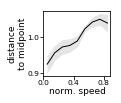

In [41]:
''' Fig. 4j -- distance to boundary vs. speed for all mice '''
f, ax = plt.subplots(1, 1, figsize=(1.2, 1.2))

xvals = np.arange(0.05, 0.95, 0.1)

# plot shuffle
# ax.plot(xvals, shuff_scores_mean, ':k', alpha=0.4, zorder=3, linewidth=1)

# plot data
ax.plot(xvals, scores_by_speed_mean, 'k', linewidth=1, zorder=1)
ax.fill_between(xvals, scores_by_speed_mean + scores_by_speed_sem,
                scores_by_speed_mean - scores_by_speed_sem, color='k', linewidth=0.2, alpha=0.1, zorder=2)

ax.set_yticks([0.9, 1.0])
ax.set_xticks([0, 0.4, 0.8])
ax.tick_params(which='major', labelsize=7.5, pad=0.5)
ax.set_xlabel('norm. speed', fontsize=9, labelpad=1)
ax.set_ylabel('distance\nto midpoint', fontsize=9, labelpad=1)

f.savefig(save_folder + 'dd_by_speed_all.png', dpi=400, bbox_inches='tight')
plt.show()

In [42]:
''' stats to determine if the scores are different across speed bins
- kruskal wallace = non-parametric test to compare multiple groups (like a non-parametric ANOVA)
- what is the best way to test each pair?
- compare each bin to the corresponding shuffle bin to see if higher or lower (again, best way to test multiple pairs?)
'''
# compare groups to each other
speed_dist_stat, speed_dist_p = stats.kruskal(norm_scores_by_speed[:, 0], norm_scores_by_speed[:, 1], 
                                              norm_scores_by_speed[:, 2], norm_scores_by_speed[:, 3], 
                                              norm_scores_by_speed[:, 4], norm_scores_by_speed[:, 5], 
                                              norm_scores_by_speed[:, 6], norm_scores_by_speed[:, 7], 
                                              norm_scores_by_speed[:, 8])
print('normalized distance score by normalized speed, kruskal wallace test, p = ' + str(np.round(speed_dist_p, 3)))

normalized distance score by normalized speed, kruskal wallace test, p = 0.0


In [43]:
''' across all sessions, is there a significant relationship between speed and score? '''
import statsmodels.api as sm

In [44]:
X = np.tile(xvals, (N_sessions, 1))
print(X.shape)
print(norm_scores_by_speed.shape)

(28, 9)
(28, 9)


In [45]:
speed_dist_model = sm.OLS(exog=norm_scores_by_speed.ravel(), endog=X.ravel())
speed_dist_results = speed_dist_model.fit()
print(speed_dist_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     882.9
Date:                Mon, 03 May 2021   Prob (F-statistic):           3.66e-84
Time:                        15:25:34   Log-Likelihood:                -2.2001
No. Observations:                 252   AIC:                             6.400
Df Residuals:                     251   BIC:                             9.930
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4567      0.015     29.714      0.0

In [46]:
# get parameters
slow_all = np.asarray([])
fast_all = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        binned_speed = d['binned_speed'].copy()
        dd_by_pos = d['pos_dist'].copy()
        
        # normalize dd_by_pos and flip sign for random 50% to correct for arbitrary map
        flat_pos = dd_by_pos.ravel()
        norm_pos = zscore(flat_pos)
        flip_idx = (np.random.rand(flat_pos.shape[0]//2)*flat_pos.shape[0]).astype(int)
        norm_pos[flip_idx] = -1*norm_pos[flip_idx]
        
        # get speed cut-offs
        flat_speed = binned_speed.ravel()
        slow_speed = np.percentile(flat_speed, 20)
        fast_speed = np.percentile(flat_speed, 80)
        
        # collect z-scored distances
        slow_all = np.append(slow_all, norm_pos[flat_speed <= slow_speed])
        fast_all = np.append(fast_all, norm_pos[flat_speed >= fast_speed])

C:\Users\ilow1\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\ilow1\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal
C:\Users\ilow1\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal


In [47]:
from sklearn.mixture import GaussianMixture

# fit a Gaussian mixture model to fast and slow
model_slow = GaussianMixture(n_components=2)
model_slow.fit(slow_all[:, None])
f1_slow = stats.norm(model_slow.means_[0], np.sqrt(model_slow.covariances_[0]))
f2_slow = stats.norm(model_slow.means_[1], np.sqrt(model_slow.covariances_[1]))

model_fast = GaussianMixture(n_components=2)
model_fast.fit(fast_all[:, None])
f1_fast = stats.norm(model_fast.means_[0], np.sqrt(model_fast.covariances_[0]))
f2_fast = stats.norm(model_fast.means_[1], np.sqrt(model_fast.covariances_[1]))

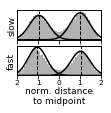

In [48]:
''' Fig. 4m -- distance to bound, slow vs. fast speeds'''
f, ax = plt.subplots(2, 1, figsize=(1.5, 1.2))
plt.subplots_adjust(hspace=0.2)
color = 'k'
MODEL_WIDTH = 1.5
MEAN_WIDTH = 1

# plot dist to cluster vs. model fit SLOW
ax[0].hist(slow_all, bins=50, color='k', alpha=0.3);
xvals = np.linspace(ax[0].get_xlim()[0], ax[0].get_xlim()[1], 200)
ax2 = ax[0].twinx()
ax2.plot(xvals, model_slow.weights_[0] * f1_slow.pdf(xvals).ravel(), color=color, lw=MODEL_WIDTH)
ax2.plot(xvals, model_slow.weights_[1] * f2_slow.pdf(xvals).ravel(), color=color, lw=MODEL_WIDTH)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.vlines(model_slow.means_, 0, ax2.get_ylim()[1], linestyles='dashed', colors='k', lw=MEAN_WIDTH)
x_min = ax[0].get_xlim()[0]
x_max = ax[0].get_xlim()[1]
ax2.set_yticks([0, 0.5])
ax[0].tick_params(labelbottom=False, labelleft=False)
ax2.tick_params(labelright=False, axis="y", which ="both", right=False)

# plot dist to cluster vs. model fit FAST
ax[1].hist(fast_all, bins=50, color='k', alpha=0.3);
xvals = np.linspace(ax[1].get_xlim()[0], ax[1].get_xlim()[1], 200)
ax2 = ax[1].twinx()
ax2.plot(xvals, model_fast.weights_[0] * f1_fast.pdf(xvals).ravel(), color=color, lw=MODEL_WIDTH)
ax2.plot(xvals, model_fast.weights_[1] * f2_fast.pdf(xvals).ravel(), color=color, lw=MODEL_WIDTH)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.vlines(model_fast.means_, 0, ax2.get_ylim()[1], linestyles='dashed', colors='k', lw=MEAN_WIDTH)
x_min = np.min((ax[1].get_xlim()[0], x_min))
x_max = np.max((ax[1].get_xlim()[1], x_max))
ax2.set_yticks([0, 0.5])

ax[1].tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
ax2.tick_params(labelright=False, axis="y", which ="both", right=False)
ax[0].tick_params(axis="y", which ="both", left=False)
ax[1].tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
ax[1].tick_params(axis="y", which ="both", left=False)

ax[0].set_xlim(x_min+1, x_max-1)
ax[1].set_xlim(x_min+1, x_max-1)
ax[1].set_xticks([-2, -1, 0, 1, 2])
ax[0].set_xticks([-2, -1, 0, 1, 2])
ax[1].set_xticklabels([2, 1, 0, 1, 2])
ax[0].set_ylabel('slow', fontsize=9, labelpad=1)
ax[1].set_ylabel('fast', fontsize=9, labelpad=1)
ax[1].set_xlabel('norm. distance\nto midpoint', fontsize=9, labelpad=1)

f.savefig(save_folder + 'speed_hist_all.png', dpi=400, bbox_inches='tight')
plt.show()

In [49]:
# save the difference in means for the good sessions
diff_median_sep = np.asarray([])
for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        dd_by_pos = d['pos_dist'].copy()
        binned_speed = d['binned_speed'].copy()
        
        # calculate the flattened vector of fast and slow speeds
        flat_pos = dd_by_pos.ravel()
        flat_speed = binned_speed.ravel()
        if np.sum(np.isnan(flat_speed)):
            flat_speed = nan_interp(flat_speed)
            
        # get the median separation for slow speeds
        slow_speed = np.percentile(flat_speed, 20)
        slow_dist = flat_pos[flat_speed<=slow_speed, None]
        d_med_slow = np.abs(np.median(slow_dist[slow_dist < 0]) - np.median(slow_dist[slow_dist > 0])) 
        
        # get the median separation for fast speeds
        fast_speed = np.percentile(flat_speed, 80)
        fast_dist = flat_pos[flat_speed>=fast_speed, None]
        d_med_fast = np.abs(np.median(fast_dist[fast_dist < 0]) - np.median(fast_dist[fast_dist > 0]))
        
        # save the difference in median separation fast vs. slow
        d_medians = d_med_fast - d_med_slow
        diff_median_sep = np.append(diff_median_sep, d_medians)       

In [50]:
# compute the shuffle distributions and difference in means
num_shuffs = 1000
diff_median_shuff = np.zeros((N_sessions, num_shuffs))
i = -1
for m, session in zip(mice, sessions):
    for s in session:
        i += 1
        d = data[m][s]
        dd_by_pos = d['pos_dist'].copy()
        binned_speed = d['binned_speed'].copy()
        flat_pos = dd_by_pos.ravel()
        flat_speed = binned_speed.ravel()
        if np.sum(np.isnan(flat_speed)):
            flat_speed = nan_interp(flat_speed)
        slow_speed = np.percentile(flat_speed, 20)
        fast_speed = np.percentile(flat_speed, 80)
            
        for k in range(num_shuffs):
            # shuffle distances
            shuff_dist = flat_pos
            np.random.shuffle(shuff_dist)
            
            # get the median separation for slow speeds
            slow_dist = shuff_dist[flat_speed<=slow_speed, None]
            d_med_slow = np.abs(np.median(slow_dist[slow_dist < 0]) - np.median(slow_dist[slow_dist > 0]))        

            # get the median separation for fast speeds
            fast_dist = shuff_dist[flat_speed>=fast_speed, None]
            d_med_fast = np.abs(np.median(fast_dist[fast_dist < 0]) - np.median(fast_dist[fast_dist > 0]))

            # save the difference in median separation fast vs. slow
            diff_median_shuff[i, k] = d_med_fast - d_med_slow

In [51]:
# for each session, get the p value
p_diff = np.zeros(N_sessions)
N_slow_sep = 0
N_fast_sep = 0
i = -1
for m, session in zip(mice, sessions):
    for s in session:
        i += 1
        pct = stats.percentileofscore(diff_median_shuff[i, :], diff_median_sep[i], kind='mean') / 100
        if pct < 0.5:
            p_diff[i] = pct * 2
            print('{}_{} slow more separated, p = {}'.format(m, s, p_diff[i]))
            N_slow_sep += 1
        else:
            p_diff[i] = (pct - 1) * 2
            print('{}_{} fast more separated, p = {}'.format(m, s, p_diff[i]))
            N_fast_sep += 1
            
print(p_diff)
print('slow more separated N = ' + str(N_slow_sep))
print('fast more separated N = ' + str(N_fast_sep))

Pisa_0430_1 fast more separated, p = 0.0
Pisa_0501_1 fast more separated, p = 0.0
Pisa_0502_1 slow more separated, p = 0.0
Hanover_0615_2 fast more separated, p = -0.0019999999999997797
Calais_0713_2 fast more separated, p = 0.0
Seattle_1005_1 fast more separated, p = 0.0
Seattle_1006_1 slow more separated, p = 0.0
Seattle_1007_1 slow more separated, p = 0.0
Portland_1005_2 slow more separated, p = 0.0
Quebec_1007_1 slow more separated, p = 0.0
Toronto_1111_1 fast more separated, p = 0.0
Toronto_1112_1 fast more separated, p = 0.0
Toronto_1113_1 fast more separated, p = -0.016000000000000014
Toronto_1114_1 slow more separated, p = 0.0
Toronto_1115_1 fast more separated, p = 0.0
Toronto_1117_1 fast more separated, p = 0.0
Vancouver_1114_1 slow more separated, p = 0.0
Vancouver_1118_1 fast more separated, p = 0.0
Mumbai_1130_1 slow more separated, p = 0.0
Mumbai_1201_1 slow more separated, p = 0.282
Mumbai_1129_1 fast more separated, p = 0.0
Kerala_1207_1 fast more separated, p = 0.0
Goa

In [52]:
''' single session examples '''
m = 'Pisa'
s = '0430_1'
d = data[m][s]

In [53]:
dd_by_pos = d['pos_dist']
binned_speed = d['binned_speed']
speed = d['A'][:, 1]
speed_bins = np.linspace(2, np.max(speed)-20, num=9)
speed_idx = np.digitize(binned_speed.ravel(), speed_bins)
flat_pos = dd_by_pos.ravel()

scores_by_speed_mean = np.zeros(9)
scores_by_speed_sem = np.zeros(9)
scores_by_speed_std = np.zeros(9)
for i, b in enumerate(np.unique(speed_idx)):
    scores_by_speed_mean[i] = np.mean(np.abs(flat_pos[speed_idx==b]))
    scores_by_speed_sem[i] = stats.sem(np.abs(flat_pos[speed_idx==b]))
    scores_by_speed_std[i] = np.std(np.abs(flat_pos[speed_idx==b]))

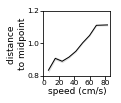

In [57]:
f, ax = plt.subplots(1, 1, figsize=(1.2, 1.2))

xvals = moving_avg(np.append(speed_bins, np.max(binned_speed)), 2)
ax.plot(xvals, scores_by_speed_mean, 'k', linewidth=1)
ax.fill_between(xvals, scores_by_speed_mean + scores_by_speed_sem,
                scores_by_speed_mean - scores_by_speed_sem, color='k', linewidth=0.3, alpha=0.1)

ax.set_yticks([0.8, 1.0, 1.2])
ax.set_xticks([0, 20, 40, 60, 80])
ax.tick_params(which='major', labelsize=7.5, pad=0.5)

ax.set_xlabel('speed (cm/s)', fontsize=9, labelpad=1)
ax.set_ylabel('distance \nto midpoint', fontsize=9, labelpad=1)

f.savefig(save_folder + m + '_' + s + '_dd_by_speed.png', dpi=400, bbox_inches='tight')
plt.show()

In [55]:
flat_pos = dd_by_pos.ravel()
flat_speed = binned_speed.ravel()
slow_speed = np.percentile(flat_speed, 20)
fast_speed = np.percentile(flat_speed, 80)

# fit a Gaussian mixture model to fast and slow
model_slow = GaussianMixture(n_components=2)
model_slow.fit(flat_pos[flat_speed<=slow_speed, None])
f1_slow = stats.norm(model_slow.means_[0], np.sqrt(model_slow.covariances_[0]))
f2_slow = stats.norm(model_slow.means_[1], np.sqrt(model_slow.covariances_[1]))

model_fast = GaussianMixture(n_components=2)
model_fast.fit(flat_pos[flat_speed>=fast_speed, None])
f1_fast = stats.norm(model_fast.means_[0], np.sqrt(model_fast.covariances_[0]))
f2_fast = stats.norm(model_fast.means_[1], np.sqrt(model_fast.covariances_[1]))

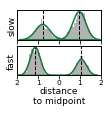

In [56]:
f, ax = plt.subplots(2, 1, figsize=(1.5, 1.2))
plt.subplots_adjust(hspace=0.2)
if m in ['Pisa', 'Hanover', 'Calais']:
    color = cp_color
else:
    color = cr_color
MODEL_WIDTH = 1.5
MEAN_WIDTH = 1

# SLOW
# histogram of distance to cluster (slowest 20%)
ax[0].hist(flat_pos[flat_speed<=slow_speed], 
           bins=50, color='k', alpha=0.3);
xvals = np.linspace(ax[0].get_xlim()[0], ax[0].get_xlim()[1], 200)

# model fit
ax2 = ax[0].twinx()
ax2.plot(xvals, model_slow.weights_[0] * f1_slow.pdf(xvals).ravel(), 
         color=color, lw=MODEL_WIDTH)
ax2.plot(xvals, model_slow.weights_[1] * f2_slow.pdf(xvals).ravel(), 
         color=color, lw=MODEL_WIDTH)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.vlines(model_slow.means_, 0, ax2.get_ylim()[1], 
           linestyles='dashed', colors='k', lw=MEAN_WIDTH)

# FAST
# histogram of distance to cluster (fastest 20%)
ax[1].hist(flat_pos[flat_speed>=fast_speed],
           bins=50, color='k', alpha=0.3);
xvals = np.linspace(ax[1].get_xlim()[0], ax[1].get_xlim()[1], 200)

# model fit
ax3 = ax[1].twinx()
ax3.plot(xvals, model_fast.weights_[0] * f1_fast.pdf(xvals).ravel(), 
         color=color, lw=MODEL_WIDTH)
ax3.plot(xvals, model_fast.weights_[1] * f2_fast.pdf(xvals).ravel(), 
         color=color, lw=MODEL_WIDTH)
ax3.set_ylim([0, ax3.get_ylim()[1]])
ax3.vlines(model_fast.means_, 0, ax3.get_ylim()[1], 
           linestyles='dashed', colors='k', lw=MEAN_WIDTH)

# SET AXIS PARAMS
ax[1].set_xticks([-2, -1, 0, 1, 2])
ax[0].set_xticks([-2, -1, 0, 1, 2])
ax[1].set_xticklabels([2, 1, 0, 1, 2])

ax[0].tick_params(labelbottom=False, labelleft=False)
ax[0].tick_params(axis="y", which ="both", left=False)
ax[1].tick_params(labelleft=False, which='major', labelsize=7.5, pad=0.5)
ax[1].tick_params(axis="y", which ="both", left=False)
ax2.tick_params(labelbottom=False, labelright=False, 
                axis="y", which ="both", right=False)
ax3.tick_params(labelright=False, axis="y", which ="both", right=False)

ax[0].set_xlim(-2, 2)
ax[1].set_xlim(-2, 2)
ax[0].set_ylabel('slow', fontsize=9, labelpad=1)
ax[1].set_ylabel('fast', fontsize=9, labelpad=1)
ax[1].set_xlabel('distance\nto midpoint', fontsize=9, labelpad=1)

f.savefig(save_folder + m + '_' + s + '_speed_hist.png', dpi=400, bbox_inches='tight')
plt.show()